In [1]:
# Helper function, used these for debugging purposes
# detector2 build only succeeds if CUDA version is correct

#!nvidia-smi
#!nvcc --version

#import torch
#torch.__version__
#import torchvision
#torchvision.__version__

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
!pip install fastai

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.0 MB 727 kB/s 
     |████████████████████████████████| 47 kB 945 kB/s 
     |████████████████████████████████| 74 kB 1.3 MB/s 
     |████████████████████████████████| 112 kB 3.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58542 sha256=7514ac48552076583a3565cf6a6c7526aa924095cf2bdfcd437d9010f8aec28e
  Stored in directory: /root/.cache/pip/wheels/a6/02/09/10e3a0150eb92e5ecbee3677a813bffc32a8ec6f876bfe4adf
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=4e2ebdb38ee88ced087e02ff0afcb3a476fdb76b26d7bc17d010c1e5a3a2b248
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272646 sha256=23ce3769c56bcbdd

Underneed you'll find the extra libraries we'll use in this notebook. More libraries will be added througout the notebook when needed.

In [2]:
# Base setup:
# detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

<a id=traincustom> </a>
## 3. Data Preparation
Let's first check our training data! Ofcourse we'll use the **Visualizer** class again.

In [3]:
# loading of data
# challenge1_path = 

training_path = "/kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/merged/merged"
train_annotation = os.path.join(training_path, "annotations/train.json")
val_annotation = os.path.join(training_path, "annotations/val.json")
image_path = os.path.join(training_path,"images")

In [4]:
os.path.exists(train_annotation)

True

In [5]:
from detectron2.structures import BoxMode
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_data", {}, train_annotation, image_path)
register_coco_instances("val_data", {}, val_annotation, image_path)

[06/23 08:51:35 d2.data.datasets.coco]: Loaded 7797 images in COCO format from /kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/merged/merged/annotations/train.json
[06/23 08:51:35 d2.data.datasets.coco]: Loaded 214 images in COCO format from /kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/merged/merged/annotations/val.json


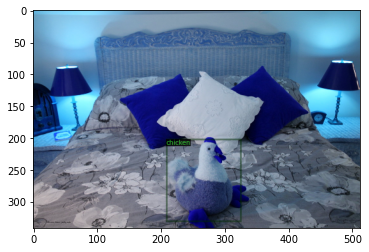

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("train_data")
dataset_dicts = DatasetCatalog.get("train_data")

my_dataset_val_metadata = MetadataCatalog.get("val_data")
val_dicts = DatasetCatalog.get("val_data")

import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

# 4. Training

In [7]:
# # DATA AUG

# from detectron2.data import transforms as T
# # Define a sequence of augmentations:
# augs = T.AugmentationList([
#     T.RandomBrightness(0.9, 1.1),
#     T.RandomFlip(prob=0.5),
#     T.RandomCrop("absolute", (640, 640))
# ])  # type: T.Augmentation

# # Define the augmentation input ("image" required, others optional):
# input = T.AugInput(image, boxes=boxes, sem_seg=sem_seg)

# # Apply the augmentation:
# transform = augs(input)  # type: T.Transform
# image_transformed = input.image  # new image
# sem_seg_transformed = input.sem_seg  # new semantic segmentation

# # For any extra data that needs to be augmented together, use transform, e.g.:
# image2_transformed = transform.apply_image(image2)
# polygons_transformed = transform.apply_polygons(polygons)

In [8]:
# # Run training

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator


class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    


#### FASTERCNN


Running the model

In [9]:
# LOADING PREV FORMAT

# from detectron2.config.config import CfgNode as CN

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("train_data",)
# cfg.DATASETS.TEST = ("val_data",)
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001
# cfg.SOLVER.WARMUP_ITERS = 1000
# cfg.SOLVER.MAX_ITER = 20000 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = [1000,8000,16000]
# cfg.SOLVER.GAMMA = 0.05
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
# # cfg.TEST.EVAL_PERIOD = 1000


# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg) 
# # trainer.resume_or_load(resume=False)

# trainer.train()

#### RetinaNet

In [10]:
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
# cfg.DATASETS.TRAIN = ("train_data",)
# cfg.DATASETS.TEST = ("val_data",)
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations enough for this dataset; Train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, enough for this dataset (default: 512)
# # cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # classes for RCNN
# cfg.MODEL.RETINANET.NUM_CLASSES = 5 # Classes for Retina
# cfg.TEST.EVAL_PERIOD = 500


# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

<a id="modelevaluation" ></a>
## 4.4. Model evaluation
Let's check out the performance of our model!

First of all let's make some predictions! We're going to use the [**DefaultPredictor**](https://detectron2.readthedocs.io/en/latest/modules/engine.html?highlight=DefaultPredictor#detectron2.engine.defaults.DefaultPredictor) class. Ofcourse we'll use the same cfg that we used during training. We'll change two parameters for our inferencing.

### Loading model

In [11]:
# RELOADING MODEL
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join("/kaggle/input/detectron-dsta-model", "model_final (3).pth")  # path to the model we trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.DATASETS.TRAIN = ("train_data",)
cfg.DATASETS.TEST = ("val_data",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 9000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = [1000,3000,6000]
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a testing threshold
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)

trainer.train()

[06/23 08:51:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[06/23 08:52:11 d2.utils.events]:  eta: 1:57:23  iter: 19  total_loss: 0.1712  loss_cls: 0.02725  loss_box_reg: 0.1485  loss_rpn_cls: 0.0004641  loss_rpn_loc: 0.004358  time: 0.7852  data_time: 0.0365  lr: 9.655e-06  max_mem: 6851M
[06/23 08:52:27 d2.utils.events]:  eta: 2:00:05  iter: 39  total_loss: 0.1601  loss_cls: 0.02778  loss_box_reg: 0.1137  loss_rpn_cls: 0.0007168  loss_rpn_loc: 0.00976  time: 0.7849  data_time: 0.0166  lr: 1.4555e-05  max_mem: 6851M
[06/23 08:52:42 d2.utils.events]:  eta: 1:58:56  iter: 59  total_loss: 0.1627  loss_cls: 0.02399  loss_box_reg: 0.1256  loss_rpn_cls: 0.0004867  loss_rpn_loc: 0.005827  time: 0.7775  data_time: 0.0128  lr: 1.9455e-05  max_mem: 6851M
[06/23 08:52:57 d2.utils.events]:  eta: 1:56:15  iter: 79  total_loss: 0.2113  loss_cls: 0.04698  loss_box_reg: 0.1597  loss_rpn_cls: 0.0006743  loss_rpn_loc: 0.006774  time: 0.7750  data_time: 0.0148  lr: 2.4355e-05  max_mem: 6851M
[06/23 08:53:13 d2.utils.events]:  eta: 1:57:25  iter: 99  total_loss:

In [12]:
predictor = DefaultPredictor(cfg)

Notice that by using the [**ColorMode.IMAGE_BW**](https://detectron2.readthedocs.io/en/latest/modules/utils.html?highlight=ColorMode#module-detectron2.utils.visualizer) we we're capable of removing the colors from objects which aren't detected!

[06/23 10:48:50 d2.data.datasets.coco]: Loaded 214 images in COCO format from /kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/merged/merged/annotations/val.json


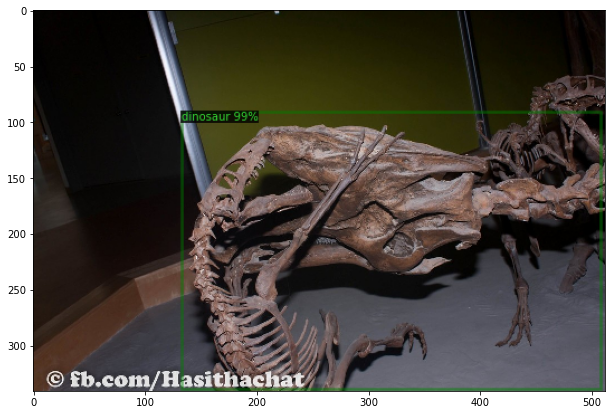

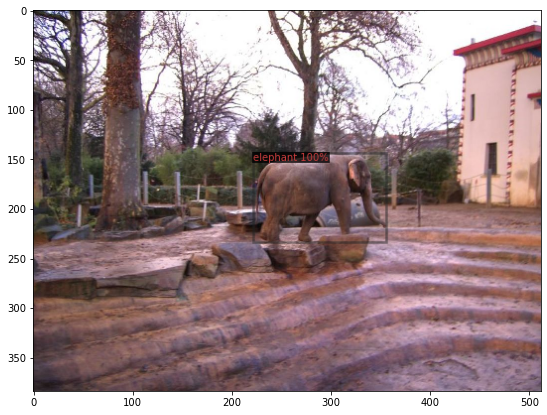

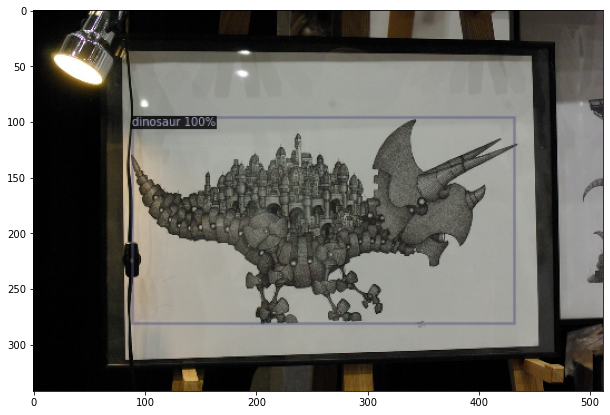

In [13]:
from detectron2.utils.visualizer import ColorMode
val_dict = DatasetCatalog.get("val_data")

for d in random.sample(val_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

Above we can see that our models performs pretty well! Let's now evaluate our custom model with [Evaluators](https://detectron2.readthedocs.io/en/latest/modules/engine.html?highlight=DefaultPredictor#detectron2.engine.defaults.DefaultPredictor). Two evaluators can be used:
* [**COCOEvaluator**](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.COCOEvaluator) can evaluate AP (Average Precision) for box detection, instance segmentation and keypoint detection.
* [**SemSegEvaluator**](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.SemSegEvaluator) can evaluate semantic segmentation metrics.

Afterwards we'll use the [**build_detection_test_loader**](https://detectron2.readthedocs.io/en/latest/modules/data.html?highlight=build_detection_test_loader#detectron2.data.build_detection_test_loader) which returns a torch DataLoader, that loads the given detection dataset.

At last we'll use the model, evaluated and dataloader within the [inference_on_dataset](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.inference_on_dataset) function. It runs the model on the dataloader and evaluates the metric with the evaluator.

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model


evaluator = COCOEvaluator("val_data", None, False, output_dir="./output/")
# evaluator = COCOEvaluator("val_data", ("bbox", "segm"), False, output_dir="./output/")

# Loading model
model_uploaded = build_model(cfg)

val_loader = build_detection_test_loader(cfg, "val_data")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))
print(inference_on_dataset(model_uploaded, val_loader, evaluator))

[06/23 10:48:54 d2.data.datasets.coco]: Loaded 214 images in COCO format from /kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/merged/merged/annotations/val.json
[06/23 10:48:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/23 10:48:54 d2.data.common]: Serializing 214 elements to byte tensors and concatenating them all ...
[06/23 10:48:54 d2.data.common]: Serialized dataset takes 0.07 MiB
[06/23 10:48:54 d2.evaluation.evaluator]: Start inference on 214 images
[06/23 10:48:55 d2.evaluation.evaluator]: Inference done 11/214. 0.0783 s / img. ETA=0:00:16
[06/23 10:49:00 d2.evaluation.evaluator]: Inference done 71/214. 0.0814 s / img. ETA=0:00:11
[06/23 10:49:05 d2.evaluation.evaluator]: Inference done 130/214. 0.0822 s / img. ETA=0:00:07
[06/23 10:49:10 d2.evaluation.evaluator]: Inference done 191/214. 0.0818 s / img. ETA=0:00:01
[06/23 10:49:12 d2.evaluatio

## Test

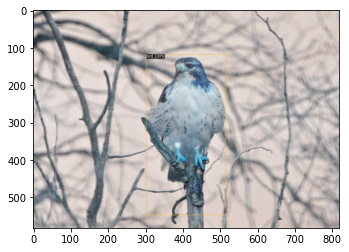

In [15]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join("/kaggle/input/objectron-retinanetv1/model_final.pth")


c3_test_path = "/kaggle/input/d/ykviki/dsta-object-detection-til-2021-dataset/challenge_3_test_dataset/challenge_3_test_dataset"

cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
test_metadata = MetadataCatalog.get("my_dataset_test")

from detectron2.utils.visualizer import ColorMode
import glob

ou_test = []
for imageName in glob.glob(os.path.join(c3_test_path,"images/*.jpg")):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  ou_test.append(outputs)
  v = Visualizer(im[:, :, ::-1],
                metadata=my_dataset_train_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.imshow(out.get_image()[:, :, ::-1])
    



In [16]:
ou_test

[{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[161.6034,  33.4710, 813.5798, 750.3752]], device='cuda:0')), scores: tensor([0.7822], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])},
 {'instances': Instances(num_instances=1, image_height=768, image_width=768, fields=[pred_boxes: Boxes(tensor([[227.9212, 104.8967, 575.7443, 692.1780]], device='cuda:0')), scores: tensor([0.9992], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])},
 {'instances': Instances(num_instances=1, image_height=684, image_width=1024, fields=[pred_boxes: Boxes(tensor([[129.0038,  66.3057, 852.5492, 609.5630]], device='cuda:0')), scores: tensor([0.9836], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])},
 {'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 24.4823, 250.2048, 896.1235, 645.5021]], device='cuda:0')), scores: tensor([0.9993], device='cu

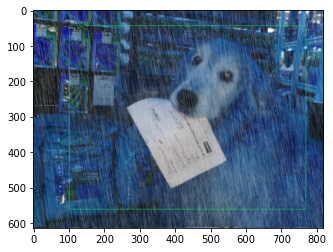

In [17]:
#
im = cv2.imread(os.path.join(c3_test_path,"images/44.jpg"))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
            metadata=my_dataset_train_metadata, 
            scale=0.8
             )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [18]:
# generate detections on the folder of test images (this will be used for submission)
from PIL import Image, ImageDraw
from torchvision import transforms
from torchvision.ops import batched_nms
from torchvision.transforms import functional as F
import torch

detections = []

for imageName in glob.glob(os.path.join(c3_test_path,"images/*.jpg")):

        im = cv2.imread(imageName)
        outputs = predictor(im)
        classes = outputs["instances"].pred_classes.tolist()
        box_round = outputs["instances"].pred_boxes.tensor.tolist()
        score_output = outputs["instances"].scores.tolist()
        head, tail = os.path.split(imageName)
        img_id = int(tail.split('.')[0])

        for i in range(len(box_round)):

            x1, y1, x2, y2 = box_round[i]
            label = int(classes[i]) + 1
            score = float(score_output[i])

            left = int(x1)
            top = int(y1)
            width = int(x2 - x1)
            height = int(y2 - y1)

            detections.append({'image_id':img_id, 'category_id':label, 'bbox':[left, top, width, height], 'score':score})

test_pred_json = os.path.join("/kaggle/working", "test_pred_2.json")
with open(test_pred_json, 'w') as f:
    json.dump(detections, f)

In [19]:
# Check 
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sample_json_path = os.path.join(c3_test_path,"c2_test_sample.json")

coco_gt = COCO(sample_json_path)
coco_dt = coco_gt.loadRes(test_pred_json)
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

<a id="othermodels" ></a>
# 5. Other models

It's possible to use other high-end object detection models aswell. Let's check it out!

<a id="keypoint" ></a>
## 5.1. Keypoint detection

Reload the data.

In [20]:
# !wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
# im = cv2.imread("./input.jpg")

In [21]:
# cfg = get_cfg()   # fresh config
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# predictor = DefaultPredictor(cfg)
# outputs = predictor(im)
# v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.figure(figsize=(15,7))
# plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

<a id="panoptic" ></a>
## 5.2. Panoptic segmentation

In [22]:
# !wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
# im = cv2.imread("./input.jpg")

In [23]:
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# plt.figure(figsize=(25,15))
# plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

<a id="semantic" ></a>
## 5.3. Semantic, Densepose, ...

Will be added in a future version! Stay tuned!

<a id="video" ></a>
# 6. Video

So up until now we've been working with images only. Can we quickly use the models for videos? The answer is YES!

<a id="videolib" ></a>
## 6.1. Libraries
As you can see we actually don't need many other libraries. Lets import a library to handle the video.

In [24]:
# from IPython.display import YouTubeVideo, display, Video # for viewing the video
# !pip install youtube-dl # for downloading the video

<a id="thevideo" ></a>
## 6.2. The video

In [25]:
# #video = YouTubeVideo("ll8TgCZ0plk", width=500)#7HaJArMDKgI
# video = YouTubeVideo("7HaJArMDKgI", width=750, height= 450)#
# display(video)

Downloading the video and cropping 6 seconds for processing


In [26]:
# !youtube-dl https://www.youtube.com/watch?v=7HaJArMDKgI -f 22 -o video.mp4
# !ffmpeg -i video.mp4 -t 00:00:10 -c:v copy video-clip.mp4 

<a id="videoinference" ></a>
## 6.3. Inference on the video
Let's now run an panoptic model over the video above.

*note: For now I'll be using some [demo](https://github.com/facebookresearch/detectron2/tree/master/demo) files, I'll later add the code implementations to this notebook.*

In [27]:
# !git clone https://github.com/facebookresearch/detectron2
# !python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output 1video-output.mkv \
#   --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

Let's check the result! 

*I've ran into some trouble with video encoding opencv and ffmpeg (fix in future version of this notebook).*

In [28]:
# !git clone https://github.com/vandeveldemaarten/tempdetector2video.git
# Video("./tempdetector2video/myvideo.mkv")

# That's all for now!

Thank you for reading this notebook! If you enjoyed it, please upvote!

*More coming soon!*